In [1]:
import xarray as xr
# Optional: plot the data (requires matplotlib)
import matplotlib.pyplot as plt
import numpy as np

# Path to your GEBCO NetCDF file
gebco_file = '/Users/mnky9800n/repos/agartha/agartha/data/dap.ceda.ac.uk/bodc/gebco/global/gebco_2025/ice_surface_elevation/netcdf/GEBCO_2025.nc'

# Open the dataset
ds = xr.open_dataset(gebco_file)

In [2]:

# Print the dataset structure to inspect available variables
print(ds)

<xarray.Dataset> Size: 7GB
Dimensions:    (lat: 43200, lon: 86400)
Coordinates:
  * lon        (lon) float64 691kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat        (lat) float64 346kB -90.0 -89.99 -89.99 ... 89.99 89.99 90.0
Data variables:
    crs        |S1 1B ...
    elevation  (lat, lon) int16 7GB ...
Attributes: (12/36)
    title:                           The GEBCO_2025 Grid - a continuous terra...
    summary:                         The GEBCO_2025 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/37c52e96-24ea-67ce-e063-708...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/37c52e96-24ea-

In [3]:
# Define bounding box for Hawaii (approximate values)
min_lon, max_lon = -161, -154
min_lat, max_lat = 18, 23

# Select the region around Hawaii
ds = ds.sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))

In [4]:
# Common variable names in GEBCO datasets:
# - 'elevation', 'lon', 'lat' or sometimes 'z', 'longitude', 'latitude'
elevation = ds['elevation']  # or ds['z']
lon = ds['lon']              # or ds['longitude']
lat = ds['lat']              # or ds['latitude']

# For quick access, convert to numpy arrays
elev_array = elevation.values
lon_array = lon.values
lat_array = lat.values


In [5]:
import torch

In [7]:
class GebcoDataset(torch.utils.data.Dataset):
    def __init__(self, netcdf_path):
        self.ds = xr.open_dataset(netcdf_path)
        self.elev_da = self.ds['elevation']
        self.lats = self.ds['lat'].values
        self.lons = self.ds['lon'].values
        
        # Print coordinate info for debugging
        print(f"Latitude range: {self.lats.min():.2f} to {self.lats.max():.2f}")
        print(f"Longitude range: {self.lons.min():.2f} to {self.lons.max():.2f}")
        print(f"Lat ascending: {self.lats[0] < self.lats[-1]}")
        
    def __len__(self):
        return len(self.lats) * len(self.lons)

    def __getitem__(self, bbox):
        lat_min, lat_max, lon_min, lon_max = bbox
        print(f"Requested bbox: lat({lat_min}, {lat_max}), lon({lon_min}, {lon_max})")
        
        # Handle longitude conversion if dataset uses 0-360
        if self.lons.min() >= 0 and lon_min < 0:
            lon_min = lon_min + 360
            lon_max = lon_max + 360
            print(f"Converted to 0-360: lon({lon_min}, {lon_max})")
        
        # Determine latitude slice order (depends on whether coords are ascending/descending)
        if self.lats[0] > self.lats[-1]:  # Descending latitudes
            lat_slice = slice(lat_max, lat_min)
        else:  # Ascending latitudes
            lat_slice = slice(lat_min, lat_max)
            
        lon_slice = slice(lon_min, lon_max)
        
        # Select subset
        elev_subset_da = self.elev_da.sel(lat=lat_slice, lon=lon_slice)
        
        print(f"Selected {len(elev_subset_da.lat)} lats, {len(elev_subset_da.lon)} lons")
        print(f"Actual lat range: {elev_subset_da.lat.values}")
        print(f"Actual lon range: {elev_subset_da.lon.values}")
        
        # Convert to tensors
        elev_subset = torch.from_numpy(elev_subset_da.values.astype(np.float32))
        lat_subset = torch.from_numpy(elev_subset_da['lat'].values.astype(np.float32))
        lon_subset = torch.from_numpy(elev_subset_da['lon'].values.astype(np.float32))
        
        return elev_subset, lat_subset, lon_subset

In [8]:
gb = GebcoDataset(netcdf_path=gebco_file)

Latitude range: -90.00 to 90.00
Longitude range: -180.00 to 180.00
Lat ascending: True


In [9]:
# Define bounding box for Hawaii (approximate values)
min_lon, max_lon = -161, -154
min_lat, max_lat = 18, 23

# Select the region around Hawaii
elev_array, lat_array, lon_array = gb[(min_lat, max_lat, min_lon, max_lon)]

Requested bbox: lat(18, 23), lon(-161, -154)
Selected 1200 lats, 1680 lons
Actual lat range: [18.00208333 18.00625    18.01041667 ... 22.98958333 22.99375
 22.99791667]
Actual lon range: [-160.99791667 -160.99375    -160.98958333 ... -154.01041667 -154.00625
 -154.00208333]


In [10]:
lat_array

tensor([18.0021, 18.0063, 18.0104,  ..., 22.9896, 22.9937, 22.9979])

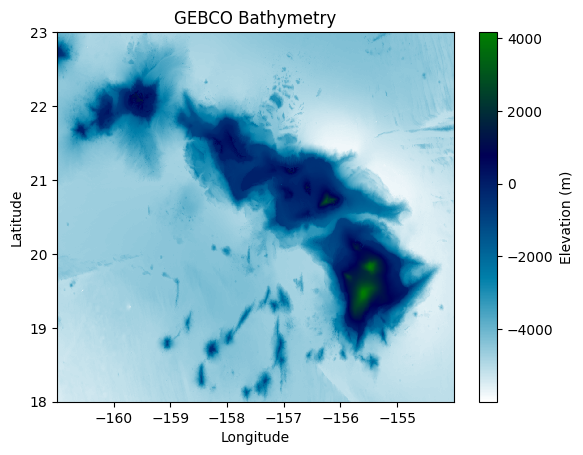

In [12]:
plt.pcolormesh(lon_array, lat_array, elev_array, cmap='ocean_r')
# plt.pcolormesh(gb.lons, gb.lats, gb.elev, cmap='ocean_r')
plt.colorbar(label='Elevation (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GEBCO Bathymetry')
plt.show()